In [1]:
import numpy as np
import ase
import spglib

from ase import build
from ase.build import supercells
from ase.spacegroup import symmetrize as ase_symmetrize

from uf3.data import composition
from uf3.representation import bspline
from uf3.regression import least_squares
from uf3.forcefield import calculator
from uf3.forcefield.properties import phonon

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [2]:
import joblib

# Demo parameters

In [3]:
filename = "potentials/manuscript_uf23.json"

In [4]:
s = 4  # supercell factor

# Load model

In [5]:
element_list = ['W']
degree = 3

chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)

In [6]:
r_min_map = {('W', 'W'): 1.5,
             ('W', 'W', 'W'): [1.5, 1.5, 1.5]
            }
r_max_map = {('W', 'W'): 5.5,
             ('W', 'W', 'W'): [4.25, 4.25, 8.5]
            }
resolution_map = {('W', 'W'): 25,
                  ('W', 'W','W'): [10, 10, 20]
                 }
pair = ("W", "W")
trio = ("W", "W", "W")

bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=3,
                                      mask_trim=True)

In [7]:
regularizer = bspline_config.get_regularization_matrix()
model = least_squares.WeightedLinearModel(regularizer=regularizer,
                                          bspline_config=bspline_config)
model.load(filename=filename)

In [8]:
calc = calculator.UFCalculator(model)

# Build BCC (2 atoms) and get lattice constant

In [9]:
a_list = np.linspace(3.0, 3.4, 51)
e_list = []
for a in tqdm(a_list):
    geom = build.bulk("W", 'bcc', a=a, cubic=True)
    geom.calc = calc
    ee = geom.get_potential_energy()
    e_list.append(ee)
a0 = a_list[np.argmin(e_list)]

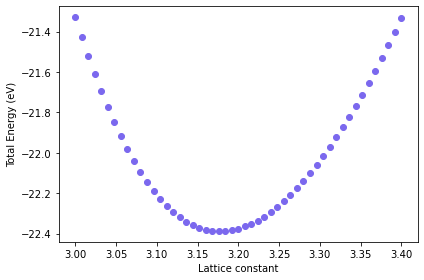

In [10]:
plt.scatter(a_list, e_list, color="mediumslateblue")
plt.xlabel("Lattice constant")
plt.ylabel("Total Energy (eV)")
plt.tight_layout()

In [11]:
geom = build.bulk("W", 'bcc', a=a0, cubic=True)
print(f"Lattice constant {a0:.3f} angstroms")

Lattice constant 3.176 angstroms


# Get primitive cell (1 atom)

In [12]:
lattice, scaled_positions, numbers = spglib.standardize_cell(geom,
                                                             to_primitive=True,
                                                             no_idealize=False,
                                                             symprec=1e-5)
geom = ase.Atoms(cell=lattice,
                 scaled_positions=scaled_positions,
                 numbers=numbers,
                 pbc=(True, True, True))

# Get elastic constants

In [13]:
elastic_constants = calc.get_elastic_constants(geom)
with np.printoptions(3, suppress=True):
    print(f"Cij (GPa): {np.array(elastic_constants[:-1])}")
    print(f"B: {elastic_constants[-1]:.3f} (GPa)")

Cij (GPa): [495.851 180.257 136.243]
B: 280.779 (GPa)


# Get Phonon Spectra

In [14]:
force_constants, path_data, bands_dict = calc.get_phonon_data(geom,
                                                              n_super=s,
                                                              disp=0.05)

In [15]:
dft_ref =[[[0.0000, 0.0000, 0.0000, 0.0000],
           [0.1294, 3.8919, 3.8919, 5.8824],
           [0.2593, 5.1683, 5.1683, 5.1683]],
          [[0.2593, 5.1683, 5.1683, 5.1683],
           [0.3656, 4.4492, 4.4492, 5.9732],
           [0.4718, 3.5877, 4.3710, 6.4989]],
          [[0.4718, 3.5877, 4.3710, 6.4989],
           [0.5466, 2.9536, 2.9536, 4.7921],
           [0.6213, 0.0000, 0.0000, 0.0000]],
          [[0.6213, 0.0000, 0.0000, 0.0000],
           [0.6861, 3.7003, 3.7003, 5.1450],
           [0.751 , 5.3080, 5.3080, 5.3080]],
          [[0.751 , 5.3080, 5.3080, 5.3080],
           [0.8752, 5.1264, 5.6094, 5.6094],
           [1.0000, 5.1531, 5.1531, 5.2941]],
          [[1.0000, 5.1531, 5.1531, 5.2941],
           [1.0641, 4.6197, 5.0059, 5.9081],
           [1.1274, 3.5723, 4.3530, 6.4834]]]
dft_ref = np.array(dft_ref)

In [16]:
distances = bands_dict['distances']
frequencies = bands_dict['frequencies']

targets = []
predictions = []
residuals = []
for interval_idx in range(len(distances)):
    target = dft_ref[interval_idx, :, 1:]
    freq = frequencies[interval_idx]
    mid_idx = int(len(freq)/2)
    prediction = np.array([freq[0], freq[mid_idx], freq[-1]])
    targets.append(np.sort(target.flatten()))
    predictions.append(np.sort(prediction.flatten()))
phonon_rmse = np.sqrt(np.mean(np.subtract(np.concatenate(targets), 
                                          np.concatenate(predictions))**2))
print(f"Phonon RMSE: {phonon_rmse:.3f} THz")

Phonon RMSE: 0.284 THz


(0.0, 7.0)

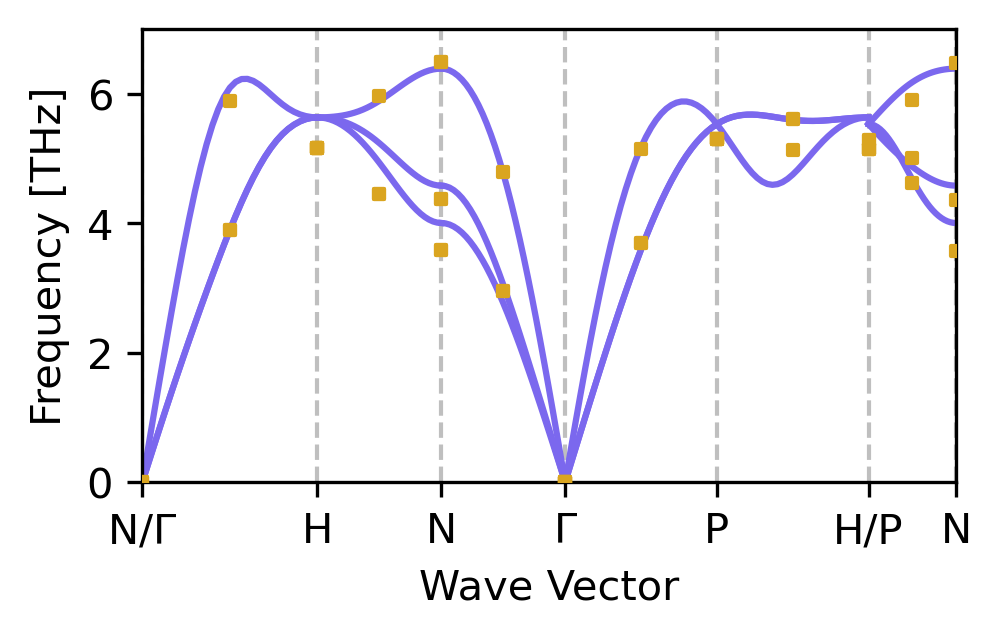

In [17]:
fig, ax = phonon.plot_phonon_spectrum(path_data, 
                                      bands_dict, 
                                      color="mediumslateblue")
factor = distances[-1][-1]

for interval_idx in range(len(distances)):
    mid_idx = int(len(freq)/2)
    wv = distances[interval_idx]
    wv = [wv[0], wv[mid_idx], wv[-1]]
    targets = dft_ref[interval_idx, :, 1:].flatten()
    plt.scatter(np.repeat(wv, 3)/factor, 
                targets, 
                color='goldenrod', 
                s=5, 
                marker='s', 
                zorder=10)
ax.set_xlim(0, 1)
ax.set_ylim(0, 7)

# Compute vacancy formation energy

In [18]:
bulk_geom = build.bulk("W", 'bcc', a=a0, cubic=True)
bulk_geom = supercells.make_supercell(bulk_geom, np.eye(3) * [s, s, s])
bulk_geom.calc = calc
pristine_energy = bulk_geom.get_potential_energy()[0] / len(bulk_geom)
print(f"Pristine energy: {pristine_energy:.3f} eV/atom")

Pristine energy: -11.194 eV/atom


In [19]:
bulk_geom.rattle(0.01)
bulk_geom = calc.relax_fmax(bulk_geom, 
                            verbose=True, 
                            relax_cell=False, 
                            fmax=0.01, 
                            timeout=120)
pristine_energy = bulk_geom.get_potential_energy()[0] / len(bulk_geom)
print(f"Pristine energy: {pristine_energy:.3f} eV/atom (relaxed)")

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  2] 18:32:00     -778.141189*       0.1423
BFGSLineSearch:    1[  5] 18:32:14     -778.166223*       0.0457
BFGSLineSearch:    2[  8] 18:32:28     -778.167845*       0.0098
Pristine energy: -11.194 eV/atom (relaxed)


In [20]:
defected_geom = bulk_geom.copy()
half_cell = np.diag(bulk_geom.cell)/2.
vac_atom = ((bulk_geom.positions - half_cell)**2).sum(axis=1).argmin()
del defected_geom[vac_atom]
defected_geom.calc = calc
defected_energy = defected_geom.get_potential_energy()[0]
print(f"Defected energy: {defected_energy:.3f} eV")

Defected energy: -1418.195 eV


In [21]:
vacancy_energy = (defected_energy - (pristine_energy * len(defected_geom)))
print(f"Unrelaxed vacancy energy: {vacancy_energy:.3f} eV")

Unrelaxed vacancy energy: 3.448 eV


In [22]:
defected_geom.rattle(0.01)
defected_geom = calc.relax_fmax(defected_geom, 
                                verbose=True, 
                                relax_cell=False, 
                                fmax=0.01, 
                                timeout=120)
defected_energy = defected_geom.get_potential_energy()[0]
print(f"Defected energy: {defected_energy:.3f} eV")

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  2] 18:32:46     -768.800352*       0.2952
BFGSLineSearch:    1[  6] 18:33:01     -768.859243*       0.0311
BFGSLineSearch:    2[  8] 18:33:13     -768.860452*       0.0136
BFGSLineSearch:    3[ 11] 18:33:27     -768.860598*       0.0037
Defected energy: -1418.415 eV


In [23]:
vacancy_energy = (defected_energy - (pristine_energy * len(defected_geom)))
print(f"Vacancy energy: {vacancy_energy:.3f} eV")

Vacancy energy: 3.228 eV


# Compute surface energies

In [24]:
bulk100 = build.bulk("W", a=a0, cubic=True)
bulk100 = supercells.make_supercell(bulk100, np.eye(3) * [4, 4, 3])

slab100 = build.bcc100(
    "W", a=a0, size=(2,2,3), vacuum=15.0, orthogonal=True)
slab110 = build.bcc110(
    "W", a=a0, size=(2,2,3), vacuum=15.0, orthogonal=True)
slab111 = build.bcc111(
    "W", a=a0, size=(2,2,3), vacuum=15.0, orthogonal=True)

bulk100.calc = calc
slab100.calc = calc
slab110.calc = calc
slab111.calc = calc

In [25]:
# Evaluate energies
e100 = bulk100.get_potential_energy(force_consistent=True) / 8
s100 = slab100.get_potential_energy(force_consistent=True)
s110 = slab110.get_potential_energy(force_consistent=True)
s111 = slab111.get_potential_energy(force_consistent=True)
# Get surface area
area100 = np.linalg.norm(np.cross(*slab100.get_cell().array[:2]), 2)
area110 = np.linalg.norm(np.cross(*slab110.get_cell().array[:2]), 2)
area111 = np.linalg.norm(np.cross(*slab111.get_cell().array[:2]), 2)
# Normalize energies
energy100 = (s100 - e100)/area100/2
energy110 = (s110 - e100)/area110/2
energy111 = (s111 - e100)/area111/2
print(f"100 Surface Energy: {energy100:.3f} eV")
print(f"110 Surface Energy: {energy110:.3f} eV")
print(f"111 Surface Energy: {energy111:.3f} eV")

100 Surface Energy: 0.233 eV
110 Surface Energy: 0.201 eV
111 Surface Energy: 0.225 eV
